# Sentiment Analysis on Movie Reviews

### Classify the sentiment of sentences from the Rotten Tomatoes dataset

[Kaggle Competition Page](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/)


The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

`train.tsv` contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.\
`test.tsv` contains just phrases. You must assign a sentiment label to each phrase.

The sentiment labels are:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

---

**This Notebook will step on with these pipelines:**

1. `Data File` $\rightarrow$ `pd.DataFrame` $\rightarrow$ `databunch(fast.ai)`


2. `pre-trained tokenizer(DistilBert)` $\rightarrow$ `Wrapped tokenizer` $\rightarrow$ `TokenizeProcessor(fast.ai)`


3. `Vocab from pre-trained tokenizer(DistilBert)` $\rightarrow$ `Wrapped Vocab` $\rightarrow$ `NumericalizeProcessor(fast.ai)`


4. `Combine(2&3)` $\rightarrow$ `fastai_processor : [TokenizeProcessor, NumericalizeProcessor]`


5. `Learner(fast.ai)` $\rightarrow$ `Splitted Learner` $\rightarrow$ `PROGRESSIVELY-FREEZING-LAYERS Training`$^{[1]}$ $\rightarrow$ `Well-trained Model`


---

**Preview on scores - @KarlSzp**

![scores.png](doc/assets/scores.png)

<img src="doc/assets/rank.png" alt="rank" style="zoom:60%;" >

## 1 Imports & Definitions

This Notebook takes the advantage of the state-of-art technique:
1. `transformers`

    transformers provides many effective pre-trained models and tokenizers for text-relative tasks.
    In this notebook, I use DistilBert.$^{[2]}$\
    DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter
    
    
2. `fast.ai`

    fast.ai provides an intergrated model `Learner()`, 
    which helps tune pre-trained model(from transformer)
    and the classifier layer added.


3. `Frame base: Pytorch`
    
    Wrapped model is inherited from `nn.Module`, as usual.

In [13]:
%matplotlib inline
import os
import gc
import json
import torch
import random
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from pathlib import Path
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from functools import partial
import transformers
import transformers.optimization as opt
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertConfig
)

from fastai.text import *
from fastai import *
from fastai.callbacks import *


# paths & dirs
train_data_path = Path("./dataset/train.tsv")
test_data_path = Path("./dataset/test.tsv")
data_bunch_path = Path("./dataset/data_bunch.pkl")
token_corpus_path = "./dataset/corpus"
data_dir = "./dataset/"
model_dir = "./models/"
submission_dir = "./submissions/"


# Global Params
RANDOM_SEED = 7
OUTPUT_SIZE = 5
EPOCHS = 100
TRAIN_RATE = 0.8
BATCH_SIZE = 16
MAX_VOCAB = 30000


# Set for Reproducity
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
assert torch.__version__ == '1.5.1'
assert transformers.__version__ == '3.0.0'

In [5]:
# Retrieve DistilBert
model = DistilBertForSequenceClassification
tokenizer = DistilBertTokenizer
config = DistilBertConfig

## 2 Implementation

In [6]:
class WrappedBaseTokenizer(BaseTokenizer):
    """
    PreTrainedTokenizer --Wrapped--> fast.ai
    """
    def __init__(self, pretrained_tokenizer, **kwargs):
        self.pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
    
    """
    Tokenize given seq in DistilBert Norms.
    DistilBert: [CLS] + tokens + [SEP] + padding
    """
    def tokenizer(self, seq):
        cls_token = self.pretrained_tokenizer.cls_token
        sep_token = self.pretrained_tokenizer.sep_token
        tokens = self.pretrained_tokenizer.tokenize(seq)
        # Mind to leave 2 spaces for cls & sep
        tokens = tokens[:self.max_seq_len-2]
        tokens = [cls_token] + tokens + [sep_token]
        return tokens
    
    # Callable for fast.ai
    def __call__(self, *args, **kwargs):
        return self


class WrappedVocab(Vocab):
    """
    Overwrite `numericalize` and `textify` functions.
    """
    def __init__(self, tokenizer):
        super(WrappedVocab, self).__init__(itos=[])
        self.tokenizer = tokenizer
    
    def numericalize(self, tokens):
        return self.tokenizer.convert_tokens_to_ids(tokens)
    
    def textify(self, ids, sep=' '):
        ids = np.array(ids).tolist()
        if sep is None:
            return self.tokenizer.convert_ids_to_tokens(ids)
        else:
            return sep.join(self.tokenizer.convert_ids_to_tokens(ids))
        
    # magic for export in fast.ai
    def __getstate__(self):
        return {
            'itos': self.itos,
            'tokenizer': self.tokenizer
        }
        
    # magic for load_learner in fast.ai
    def __setstate__(self, state):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = {value: key for key, value in enumerate(self.itos)}
        

class ModelUponDistilBert(nn.Module):
    """
    Model built upon DistilBert.
    """
    def __init__(self, pretrained_model):
        super(ModelUponDistilBert, self).__init__()
        self.pretrained_model = pretrained_model
        
    def forward(self, input_ids, attention_mask=None):
        # attention_mask to tell [PAD] from other tokens.
        attention_mask = (input_ids != tokenizer.pad_token_id).type(input_ids.type())
        
        # generate logits for classifier
        logits = self.pretrained_model(input_ids=input_ids,
                                       attention_mask=attention_mask)[0]
        return logits

In [7]:
# Tokenizer for fast.ai
tokenizer = tokenizer.from_pretrained("distilbert-base-uncased")
wrapped_tokenizer = WrappedBaseTokenizer(pretrained_tokenizer=tokenizer)
fastai_tokenizer = Tokenizer(tok_func=wrapped_tokenizer, 
                             pre_rules=[], post_rules=[])

In [8]:
# Vocab for fast.ai
wrapped_vocab = WrappedVocab(tokenizer=tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=wrapped_vocab,
                                               max_vocab=MAX_VOCAB)

In [9]:
# Processor for fast.ai
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer,
                                       include_bos=False)

fastai_processor = [tokenize_processor, numericalize_processor]

So far, I've instantiated the processor to build databunch:

`fastai_processor : [tokenize_processor, numericalize_processor]`

it process data to tokens and numericalize tokens to ids.

---

## 3 Build databunch

In [10]:
# Util - Load Data
def generateCorpus(data_path, save_corpus=True):
    df = pd.read_table(data_path)
    corpus = " ".join(list(df.Phrase.values))
    if os.path.exists(token_corpus_path):
        print("Corpus existed. Overwriting...")
    with open(token_corpus_path, "w") as f:
        f.write(corpus)
    
    return df, corpus

train_df, corpus = generateCorpus(train_data_path)
test_df, _ = generateCorpus(test_data_path, save_corpus=False)

TRAIN_SIZE = train_df.shape[0]

Corpus existed. Overwriting...
Corpus existed. Overwriting...


In [11]:
# Generate databunch
data_bunch = (TextList.from_df(train_df, cols='Phrase', 
                               processor=fastai_processor)
              .split_by_rand_pct(valid_pct=(1-TRAIN_RATE), seed=RANDOM_SEED)
              .label_from_df(cols='Sentiment')
              .add_test(test_df)
              .databunch(bs=BATCH_SIZE,
                         pad_first=False,
                         pad_idx=tokenizer.pad_token_id))

In [12]:
data_bunch.show_batch()

text,target
"[CLS] - l ##rb - city - rr ##b - reminds us how realistic ##ally nu ##ance ##d a robert de ni ##ro performance can be when he is not more lucrative ##ly engaged in the shame ##less self - car ##ica ##ture of ` analyze this ' - l ##rb - 1999 - rr ##b - and ` analyze that , ' promised - l ##rb - or threatened",3
"[CLS] it ' s too harsh to work as a piece of storytelling , but as an intellectual exercise - - an unpleasant debate that ' s been given the drive of a narrative and that ' s been acted out - - the believer is nothing less than a provocative piece of work [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",2
"[CLS] a bon ##anza of wa ##cky sight gag ##s , out ##land ##ish color schemes , and corn ##y visual pun ##s that can be appreciated equally as an abstract frank ta ##sh ##lin comedy and as a playful rec ##ap ##it ##ulation of the artist ' s career . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",2
"[CLS] if you ' re the kind of parent who enjoys intentionally introducing your kids to films which will cause loads of ir ##re ##para ##ble damage that years and years of costly analysis could never fix , i have just one word for you - - - dec ##asia [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",0
"[CLS] jones , despite a definitely distinctive screen presence , just is n ' t able to muster for a movie that , its title notwithstanding , should have been a lot nas ##tier if it wanted to fully capital ##ize on its lead ' s specific gifts . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",1


## 4 Set the Learner

In [15]:
# Config
config = config.from_pretrained("distilbert-base-uncased")
config.num_labels = 5

# Model Instance
model = model.from_pretrained("distilbert-base-uncased", config=config)
fastai_model = ModelUponDistilBert(pretrained_model=model)

# Use optimized Adam as optimizer
opt_AdamW = partial(opt.AdamW, correct_bias=False)

In [16]:
# Instantiate a Learner
learner = Learner(data=data_bunch,
                  model=fastai_model,
                  opt_func=opt_AdamW,
                  metrics=[accuracy, error_rate],
                  silent=False)

learner.callbacks.append(ShowGraph(learner))

To apply the freeze-out technique, overlook the learner and split it into several layers of model.

The learner is stacked as:
1. distilbert
    1. embeddings
    2. transformer
        1. layer - 0\
        ...
        6. layer - 5
2. pre_classifier

In [17]:
learner.model.named_modules

<bound method Module.named_modules of ModelUponDistilBert(
  (pretrained_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), e

In this term, the splitting strategy comes as follow:

In [18]:
split_layers = [learner.model.pretrained_model.distilbert.embeddings,
                learner.model.pretrained_model.distilbert.transformer.layer[0],
                learner.model.pretrained_model.distilbert.transformer.layer[1],
                learner.model.pretrained_model.distilbert.transformer.layer[2],
                learner.model.pretrained_model.distilbert.transformer.layer[3],
                learner.model.pretrained_model.distilbert.transformer.layer[4],
                learner.model.pretrained_model.distilbert.transformer.layer[5],
                learner.model.pretrained_model.pre_classifier]

In [19]:
learner.split(split_layers)
# goups_len is used to initiate 
# the learning rate, in next section.
groups_len = len(learner.layer_groups)
print('Learner split in',groups_len,'groups')

Learner split in 8 groups


---
## 5 Training

**Remember to skip this section and do benchmarking!**

In [15]:
learner.model_dir = model_dir
learner.save('raw_model')

Freeze until the last second group, and find the best learning rate.


**BTW**:\
Some may argue that WHY NOT CHOOSING the LR with lowest loss, however, refering to many blogs and fast.ai tutorial, a LR that still have space to be optimized is preferred.

In [16]:
# Freeze until the last second group
learner.freeze_to(-1)

In [17]:
lr = learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.91E-05


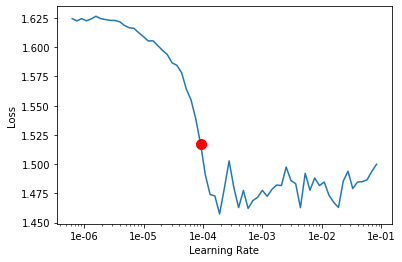

In [18]:
learner.recorder.plot(skip_end=20, suggestion=True)

In [19]:
def train_func(learner, cyc_len=1, freeze_n=None, best_lr=2e-04, save=False):
    if freeze_n is not None:
        learner.freeze_to(freeze_n)
    else:
        learner.unfreeze()
    
    learner.fit_one_cycle(cyc_len, max_lr=best_lr)
    learner.save('model-freeze-to-{}'.format(str(freeze_n) if freeze_n is not None else "None"))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.903059,0.888748,0.635705,0.364295,03:11


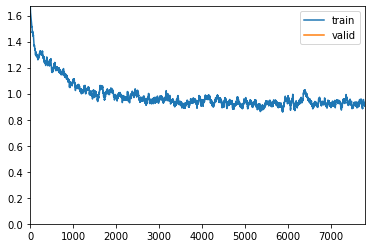

In [20]:
# Freeze until the last second group and train
train_func(learner, 1, -1, save=True)

After training ONLY the last group(the classifier), use a slice of LR instead of scalar, in order to "warm up".

In [ ]:
best_lr_interval = slice(1e-5*0.95**groups_len, 1e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.886235,0.843399,0.651416,0.348584,04:48


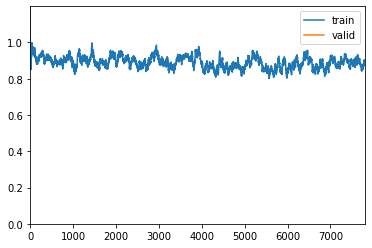

In [26]:
# Freeze until the last third group and train
train_func(learner, 1, -2, best_lr_interval, save=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.824864,0.810565,0.663591,0.336409,06:30


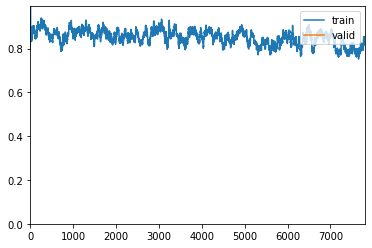

In [30]:
# Freeze until the last fourth group and train
train_func(learner, 1, -3, best_lr_interval, save=True)

Then, unfreeze all and train.

In [33]:
train_func(learner, 3, None, best_lr_interval, save=True)

Training process done, and export the learner.

In [ ]:
learner.export(file='transformer.pkl')

**NB**:
1. Since my device is not strong enough to support the training demand(Geforce 1050, Nvidia), the training process was actually done in Google Colab with free GPU.
2. I download the final model and predictions from my google drive, and directly load them from files in the next benchmarking section.
3. If necessary, you could run the training process on your device without modifying code above.

## 6 Benchmarking

In [18]:
trained_learner = load_learner(model_dir, file = 'transformer.pkl')

**Try it on some Interesting corpus here!**

Note that:\
The sentiment labels are:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [26]:
def predict(seq):    
    sentiment_dict = {
        0: "negative",
        1: "somewhat negative",
        2: "neutral",
        3: "somewhat positive",
        4: "positive"
    }
    return sentiment_dict[int(trained_learner.predict(seq)[1])]

In [30]:
predict("This movie is quite interesting!!")

'positive'

In [31]:
predict("This movie is really boring!!")

'negative'

In [35]:
predict("This movie deserve it!")

'somewhat positive'

In [36]:
predict("This movie is a waste of time!")

'negative'

In [40]:
predict("This movie is a bit boring.")

'somewhat negative'

In [50]:
predict("This movie is good at plot.")

'somewhat positive'

In [51]:
predict("This movie is bad at acting.")

'somewhat negative'

In [52]:
predict("This movie is good at plot while bad at acting.")

'neutral'

In [24]:
with open(data_dir+"predictions.pkl", "rb") as f:
    predictions = pkl.load(f)

assert predictions.shape[1] == 5

In [28]:
###
# If you run the process on your device, 
# ********* un-comment-out ********* 
# the following sentences to generate predictions on test file：
###

"""
get_pred() method automatically do predictions on test data in databunch.

Note:
1. Generate databunch
data_bunch = (...
              .add_test(test_df)
              ...)
2. Use *.detach().cpu() to detach data to cpu since code on host 
   cannot visit or operate on data attached to GPU.
"""
# predictions = learner.get_preds(DatasetType.Test)[0].detach().cpu().numpy()


"""
These pieces of code are tricky, 
to sort the predicitons into origin order.

Note:
Since predictions are done parallelly, 
so the order is not guaranteed to keep still.
"""
# sampler = [i for i in data_bunch.dl(DatasetType.Test).sampler]
# idx = np.argsort(sampler)
# indexed_predictions = predictions[idx, :]
# indexed_predictions = np.argmax(indexed_predictions, axis=1)


"""
Dump the result as submission to Kaggle.
"""
# test_pred_dict = {"PhraseId":test_df.PhraseId.values, 
#                   "Sentiment": indexed_predictions}
# test_pred = pd.DataFrame(test_pred_dict)
# i = 0
# while os.path.exists(submission_dir+"submission_{}.csv".format(i)):
#     i += 1
# test_pred.to_csv(submission_dir+"submission_{}.csv".format(i), index=False)

**NB:**\
[1]: [arXiv: FREEZEOUT: ACCELERATE TRAINING BY PROGRESSIVELY FREEZING LAYERS by Andrew Brock, Theodore Lim, J.M. Ritchi and Nick Weston.](https://arxiv.org/pdf/1706.04983.pdf)
[2]: [arXiv: DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter by Victor Sanh, Lysandre Debut, Julien Chaumond, Thomas Wolf](https://arxiv.org/abs/1910.01108)

---
**Karl 2020/7**